In [1]:
%matplotlib widget
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import gymnasium as gym
import csv
import time
from gym.wrappers import RecordVideo

from tqdm import tqdm 

import pickle as pkl
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
os.makedirs('./data', exist_ok=True)

In [3]:
class ConditionalDiffusionNet(nn.Module):
    def __init__(self,data_dim,cond_dim):
        super(ConditionalDiffusionNet,self).__init__()
        n_unit = 256

        self.l1 = nn.Linear(data_dim, n_unit)
        self.l2 = nn.Linear(n_unit, n_unit)

        self.l1_beta = nn.Linear(1, n_unit)
        self.l2_beta = nn.Linear(n_unit, n_unit)

        self.l1_cond = nn.Linear(cond_dim, n_unit)
        self.l2_cond = nn.Linear(n_unit, n_unit)

        self.l3 = nn.Linear(n_unit,n_unit)
        self.l4 = nn.Linear(n_unit,data_dim)
    
    def forward(self,x,c,t):
        xx = self.l1(x)
        xx = F.relu(xx)
        xx = self.l2(xx)
        xx = F.relu(xx)

        cc = self.l1_cond(c)
        cc = F.relu(cc)
        cc = self.l2_cond(cc)
        cc = F.relu(cc)

        bb = self.l1_beta(t)
        bb = F.relu(bb)
        bb = self.l2_beta(bb)
        bb = F.relu(bb)

        xx = self.l3(xx+bb+cc)
        xx = F.relu(xx)
        xx = self.l4(xx)

        return xx

In [4]:
class ConditionalDenoisingDiffusionProbabilisticModel():
    def __init__(self, X, cond, beta, device, batch_size=32):
        self.device = device

        self.X = X
        self.x_dim = self.X.shape[1]
        self.C = cond
        self.c_dim = self.C.shape[1]
        self.beta = beta
        self.n_beta = self.beta.shape[0]

        alpha = 1 - self.beta
        self.alpha = torch.tensor([[torch.prod(alpha[:i+1])] for i in range(self.n_beta)]).float()

        self.batch_size = batch_size

        self.model = ConditionalDiffusionNet(self.X.shape[1], self.C.shape[1]).to(self.device)

        train_dataset = torch.utils.data.TensorDataset(self.X, self.C)
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)



    def learning(self, n_epoch=10):
        self.model.train()

        for e in range(n_epoch):
            for (x_batch, c_batch) in self.train_loader:
                loss_hist = []

                x_batch = x_batch
                c_batch = c_batch
                
                self.optimizer.zero_grad()

                t = torch.randint(low=0, high=self.n_beta, size=(x_batch.shape[0],))
                noise = torch.randn(x_batch.shape[0], self.x_dim)


                x_t = torch.sqrt(self.alpha[t]) * x_batch + torch.sqrt(1-self.alpha[t]) * noise

                noise_pred = self.model(x_t.to(self.device),
                                        c_batch.to(self.device),
                                        t[:,None].float().to(self.device))


                # import ipdb; ipdb.set_trace()
                loss = ((noise_pred - noise.to(device))**2).sum()
                loss_hist.append(loss.detach().cpu().numpy()/x_batch.shape[0])

                loss.backward()

                self.optimizer.step()

            print('epoch: {}, loss: {}'.format(e, np.array(loss_hist).mean()))

        self.model.eval()



    def sampling(self, c, n=100):
        x_sample = torch.randn(n, self.x_dim)
        c_sample = c.repeat(n, 1)

        for t in range(self.n_beta)[::-1]:
            noise = torch.randn(n, self.x_dim)
            if t==0: noise= torch.zeros(n, self.x_dim)

            sigma = torch.sqrt(self.beta[t]*(1-self.alpha[t-1])/(1-self.alpha[t]))

            noise_pred = self.model(x_sample.to(self.device),
                                    c_sample.to(self.device),
                                    torch.tensor([[t]]).float().to(self.device)).detach().cpu()

            # import ipdb;ipdb.set_trace()
            x_sample = (x_sample - self.beta[t]*noise_pred/torch.sqrt(1-self.alpha[t])) / torch.sqrt(1-self.beta[t]) + sigma * noise


        return x_sample

In [5]:
file_path = './data/fixed_policy_data_2.csv'
data = pd.read_csv(file_path)

# extraction: timestamp, action, position, velocity
x = data['action'].values[:,None]
c = data[['position', 'velocity']].values 

### Learning 

In [ ]:
beta = np.exp(np.linspace(np.log(0.001), np.log(0.9), 300))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ddpm = ConditionalDenoisingDiffusionProbabilisticModel(
                torch.tensor(x).float(),
                torch.tensor(c).float(),
                torch.tensor(beta).float(), device, batch_size=32)

ddpm.learning(100)

with open('./data/fixed_policy_data_2.pkl', 'wb') as f:
    pkl.dump(ddpm, f)

### multiple learning 

take multiple expert demonstration trajectories, do the sampling and save each learned weight with the same name as dataset name

In [5]:
beta = np.exp(np.linspace(np.log(0.001), np.log(0.9), 300))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def single_csv_learning(file_path, file_name):
    data = pd.read_csv(file_path)

    # 提取 action, position, velocity
    x = data['action'].values[:, None]
    c = data[['position', 'velocity']].values

    ddpm = ConditionalDenoisingDiffusionProbabilisticModel(
        torch.tensor(x).float(),
        torch.tensor(c).float(),
        torch.tensor(beta).float(), device, batch_size=32)

    ddpm.learning(100)

    # 保存为和 csv 同名但扩展名为 .pkl 的文件
    pkl_file_path = f'./data2/{file_name}.pkl'
    with open(pkl_file_path, 'wb') as f:
        pkl.dump(ddpm, f)

# 黑名单集合，存储已处理的文件名
blacklist = set()

data_dir = './data'
# 使用 tqdm 显示进度
for file_name in tqdm(os.listdir(data_dir), desc="Processing files"):
    if file_name.endswith('.csv') and file_name not in blacklist:
        file_path = os.path.join(data_dir, file_name)

        try:
            # 去掉 .csv 扩展名传递给 single_csv_learning 函数
            single_csv_learning(file_path, file_name.replace('.csv', ''))
            # 将处理过的文件加入黑名单
            blacklist.add(file_name)
        
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            continue    

Processing files:   0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0, loss: 16.350369262695313
epoch: 1, loss: 2.6138636271158853
epoch: 2, loss: 1.080499521891276
epoch: 3, loss: 1.0166065216064453
epoch: 4, loss: 1.3026686350504557
epoch: 5, loss: 0.9060092290242513
epoch: 6, loss: 0.858195686340332
epoch: 7, loss: 0.5087368011474609
epoch: 8, loss: 0.5733917236328125
epoch: 9, loss: 0.7191641489664714
epoch: 10, loss: 0.23869250615437826
epoch: 11, loss: 0.3083362897237142
epoch: 12, loss: 0.8755966186523437
epoch: 13, loss: 0.6307959238688151
epoch: 14, loss: 0.6892547607421875
epoch: 15, loss: 0.2744225184122721
epoch: 16, loss: 0.3181834856669108
epoch: 17, loss: 0.35249220530192055
epoch: 18, loss: 0.2860433578491211
epoch: 19, loss: 0.30981998443603515
epoch: 20, loss: 0.20899372100830077
epoch: 21, loss: 0.8583404541015625
epoch: 22, loss: 0.7347379048665365
epoch: 23, loss: 0.32317091623942057
epoch: 24, loss: 0.533729616800944
epoch: 25, loss: 0.4638292630513509
epoch: 26, loss: 0.7673109690348308
epoch: 27, loss: 0.45662180582682294

Processing files:  14%|█▍        | 1/7 [00:05<00:35,  5.98s/it]

epoch: 98, loss: 0.45257822672526044
epoch: 99, loss: 0.07951862812042236
epoch: 0, loss: 5.406545639038086
epoch: 1, loss: 0.8397524952888489
epoch: 2, loss: 1.3966659307479858
epoch: 3, loss: 0.003974352031946182
epoch: 4, loss: 1.9434664249420166
epoch: 5, loss: 3.115823268890381
epoch: 6, loss: 0.6222567558288574
epoch: 7, loss: 0.0630580335855484
epoch: 8, loss: 0.05908681079745293
epoch: 9, loss: 0.6102582216262817
epoch: 10, loss: 0.13570861518383026
epoch: 11, loss: 3.0163745880126953
epoch: 12, loss: 0.008346295915544033
epoch: 13, loss: 1.270737648010254
epoch: 14, loss: 5.019371032714844
epoch: 15, loss: 0.009881636127829552
epoch: 16, loss: 2.247087240219116
epoch: 17, loss: 0.06422857940196991
epoch: 18, loss: 0.9106590151786804
epoch: 19, loss: 0.18401268124580383
epoch: 20, loss: 0.03550712764263153
epoch: 21, loss: 0.17695124447345734
epoch: 22, loss: 0.0673002377152443
epoch: 23, loss: 1.3789949417114258
epoch: 24, loss: 0.0024885828606784344
epoch: 25, loss: 0.1126555

Processing files:  29%|██▊       | 2/7 [00:10<00:26,  5.29s/it]

epoch: 0, loss: 11.436300659179688
epoch: 1, loss: 1.2882562001546225
epoch: 2, loss: 0.7257606506347656
epoch: 3, loss: 0.575365956624349
epoch: 4, loss: 0.41376533508300783
epoch: 5, loss: 0.27341219584147136
epoch: 6, loss: 0.26927433013916013
epoch: 7, loss: 0.25611432393391925
epoch: 8, loss: 0.34649461110432944
epoch: 9, loss: 0.14460994402567545
epoch: 10, loss: 0.34976787567138673
epoch: 11, loss: 0.26412984530131023
epoch: 12, loss: 0.39315255482991535
epoch: 13, loss: 0.1952739715576172
epoch: 14, loss: 0.28752409617106117
epoch: 15, loss: 0.19835376739501953
epoch: 16, loss: 0.24047104517618814
epoch: 17, loss: 1.0000773111979167
epoch: 18, loss: 0.2981652577718099
epoch: 19, loss: 0.2476406415303548
epoch: 20, loss: 0.26407580375671386
epoch: 21, loss: 0.3569254239400228
epoch: 22, loss: 0.3263075510660807
epoch: 23, loss: 0.5101288477579753
epoch: 24, loss: 0.7528294881184896
epoch: 25, loss: 0.2735202471415202
epoch: 26, loss: 0.25463104248046875
epoch: 27, loss: 0.419962

Processing files:  43%|████▎     | 3/7 [00:16<00:21,  5.44s/it]

epoch: 97, loss: 0.047827517986297606
epoch: 98, loss: 0.2247066815694173
epoch: 99, loss: 0.043107493718465166
epoch: 0, loss: 2.8650665283203125
epoch: 1, loss: 2.188449982673891
epoch: 2, loss: 0.44529804106681575
epoch: 3, loss: 0.9030729724514869
epoch: 4, loss: 0.48200921089418475
epoch: 5, loss: 0.3688121611072171
epoch: 6, loss: 0.48987542429277975
epoch: 7, loss: 0.41132850031698903
epoch: 8, loss: 0.4597425768452306
epoch: 9, loss: 0.3234689466414913
epoch: 10, loss: 0.2539183708929246
epoch: 11, loss: 0.4256536114600397
epoch: 12, loss: 0.8126009664227886
epoch: 13, loss: 0.6294655953684161
epoch: 14, loss: 0.2694383744270571
epoch: 15, loss: 0.3199706846667874
epoch: 16, loss: 0.2902959392916772
epoch: 17, loss: 0.28085284079274825
epoch: 18, loss: 0.3265017847861013
epoch: 19, loss: 0.6564478720388105
epoch: 20, loss: 0.3813126779371692
epoch: 21, loss: 0.1505498270834646
epoch: 22, loss: 0.49382794287896925
epoch: 23, loss: 0.3688703044768303
epoch: 24, loss: 0.1828206277

Processing files:  57%|█████▋    | 4/7 [00:23<00:17,  5.96s/it]

epoch: 97, loss: 0.06280571414578345
epoch: 98, loss: 0.05482791316124701
epoch: 99, loss: 0.1882317143101846
epoch: 0, loss: 17.515577528211807
epoch: 1, loss: 1.6150321960449219
epoch: 2, loss: 0.8327495786878798
epoch: 3, loss: 0.7333508067660861
epoch: 4, loss: 0.3585252496931288
epoch: 5, loss: 0.5549363030327691
epoch: 6, loss: 0.30908891889784074
epoch: 7, loss: 0.41880740059746635
epoch: 8, loss: 0.4214954906039768
epoch: 9, loss: 0.17189464304182264
epoch: 10, loss: 0.24988675117492676
epoch: 11, loss: 0.5948171615600586
epoch: 12, loss: 0.28240010473463273
epoch: 13, loss: 0.5604893366495768
epoch: 14, loss: 0.2793392605251736
epoch: 15, loss: 0.5298058191935221
epoch: 16, loss: 0.2506721019744873
epoch: 17, loss: 0.5808359781901041
epoch: 18, loss: 0.806207021077474
epoch: 19, loss: 0.38391802046034074
epoch: 20, loss: 0.6014749738905165
epoch: 21, loss: 0.40463823742336696
epoch: 22, loss: 0.3447977172003852
epoch: 23, loss: 0.31475501590304905
epoch: 24, loss: 0.3672450383

Processing files:  71%|███████▏  | 5/7 [00:31<00:13,  6.68s/it]

epoch: 99, loss: 0.3534204959869385
epoch: 0, loss: 15.79803466796875
epoch: 1, loss: 1.621911279086409
epoch: 2, loss: 0.7276016103810278
epoch: 3, loss: 0.6630429892704405
epoch: 4, loss: 0.5545257042194235
epoch: 5, loss: 0.5570781313139817
epoch: 6, loss: 0.6542946387981546
epoch: 7, loss: 0.3777321782605401
epoch: 8, loss: 0.48149559415619947
epoch: 9, loss: 0.10739471172464304
epoch: 10, loss: 0.3274809738685345
epoch: 11, loss: 0.5830539177204
epoch: 12, loss: 0.5840654044315733
epoch: 13, loss: 0.30816939781452046
epoch: 14, loss: 0.17712920287559772
epoch: 15, loss: 0.3772789527629984
epoch: 16, loss: 0.11611156628049653
epoch: 17, loss: 0.24135607686536065
epoch: 18, loss: 0.3321735776703933
epoch: 19, loss: 0.4261784389101226
epoch: 20, loss: 0.3586156779322131
epoch: 21, loss: 0.21527208130935144
epoch: 22, loss: 0.36831013909701643
epoch: 23, loss: 0.2337665393434722
epoch: 24, loss: 0.2777396234972724
epoch: 25, loss: 0.2043849353132577
epoch: 26, loss: 0.1964291539685479

Processing files:  86%|████████▌ | 6/7 [00:39<00:07,  7.25s/it]

epoch: 97, loss: 0.04836554362856109
epoch: 98, loss: 0.08298064922464304
epoch: 99, loss: 0.02694301153051442
epoch: 0, loss: 6.74764887491862
epoch: 1, loss: 0.6044196022881402
epoch: 2, loss: 0.4530499776204427
epoch: 3, loss: 0.7083673477172852
epoch: 4, loss: 0.47869184282090926
epoch: 5, loss: 0.328928099738227
epoch: 6, loss: 0.563510947757297
epoch: 7, loss: 0.30487460560268825
epoch: 8, loss: 0.11788153648376465
epoch: 9, loss: 0.4534008238050673
epoch: 10, loss: 0.27457112736172146
epoch: 11, loss: 0.598754776848687
epoch: 12, loss: 0.3643437491522895
epoch: 13, loss: 0.21880409452650282
epoch: 14, loss: 0.5365364816453722
epoch: 15, loss: 0.22169805897606742
epoch: 16, loss: 0.15527314609951443
epoch: 17, loss: 0.34998732142978245
epoch: 18, loss: 0.24785900115966797
epoch: 19, loss: 0.362190670437283
epoch: 20, loss: 0.1518367264005873
epoch: 21, loss: 0.17610157860649955
epoch: 22, loss: 0.27417967054578996
epoch: 23, loss: 0.23680347866482204
epoch: 24, loss: 0.3936089939

Processing files: 100%|██████████| 7/7 [00:49<00:00,  7.03s/it]


### Sampling 

In [7]:
# def predict_and_execute(env, ddpm, device, n_steps, output_file = 'execution_log.csv'):
#     # observation from gym evironment
#     observation, _ = env.reset()

#     # initialize a dataframe to log the data
#     log_data =[]

#     for step in range(n_steps):
#         position = observation[0]
#         velocity = observation[1]

#         c_tensor = torch.tensor([[position, velocity]], dtype = torch.float32).to(device)

#         with torch.no_grad():
#             action_tensor = ddpm.sampling(c_tensor,1)
        
#         action = action_tensor.cpu().numpy().flatten()

#         print("action is ", action)

#         # execute action in the environment
#         observation, reward, done,_,_ = env.step(action)

#         env.render()

#         timestamp = time.time()

#         # log data into csv file
#         log_data.append({'timestamp':timestamp, 'action':action[0], 'position':position, 'velocity': velocity})

#         if done:
#             break

#         time.sleep(0.1)
    
#     log_df = pd.DataFrame(log_data)
#     log_df.to_csv(output_file , index = False)      

In [8]:
# if __name__ == '__main__':
#     env = gym.make('MountainCarContinuous-v0', render_mode="human")
#     ddpm = ConditionalDenoisingDiffusionProbabilisticModel(torch.tensor(x).float(),
#                 torch.tensor(c).float(),
#                 torch.tensor(beta).float(), device, batch_size=32)
#     predict_and_execute(env,ddpm, device, n_steps=3000)

# good sampling code without recording the inference trajectory

this code can display the sampling (inference) result, but it cannot save them

In [12]:
if __name__=='__main__':

    with open('./data/manual_policy_50_LR_RLR.pkl', 'rb') as f:
        policy_ddpm = pkl.load(f)


    # env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")
    env = gym.make('MountainCarContinuous-v0', render_mode="human")

    data_state = []
    data_action = []

    for e in range(5):
        states = []
        actions = []
    
        observation, info = env.reset()
        
        for i in range(1000):
            # env.render()
        
            # action = env.action_space.sample()
            action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)
            action = action[0].numpy()

            observation, reward, terminated, truncated, info = env.step(action)

            states.append(observation)
            actions.append(action)
        
            # print(i, observation, action, reward, terminated)
        
            if terminated or truncated:
                break
                # observation, info = env.reset()

        data_state.append(np.array(states))
        data_action.append(np.array(actions))
    
    env.close()

## good sampling code with recording function

This code can save the sampling result, but it cannot display as the render_mode is rgb_array

In [ ]:
if __name__=='__main__':
    with open('./data/fixed_policy_data_2.pkl', 'rb') as f:
        policy_ddpm = pkl.load(f)

    # 为环境添加视频录制功能
    env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(env, './videos', episode_trigger=lambda e: True)  # 将视频保存到 './videos' 文件夹中

    data_state = []
    data_action = []

    for e in range(5):
        states = []
        actions = []
    
        observation, info = env.reset()
        
        for i in range(1000):
            # 动作采样
            action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)
            action = action[0].numpy()

            # 应用动作并获取新的状态和奖励
            observation, reward, terminated, truncated, info = env.step(action)

            states.append(observation)
            actions.append(action)
        
            if terminated or truncated:
                break

        # 保存每个 episode 的状态和动作数据
        data_state.append(np.array(states))
        data_action.append(np.array(actions))
    
    env.close()

    # 保存数据
    with open('./data/recorded_states.pkl', 'wb') as f:
        pkl.dump(data_state, f)
    with open('./data/recorded_actions.pkl', 'wb') as f:
        pkl.dump(data_action, f)

Multiple inference part

input : multiple pkl weights 

output : corresponding sampling (inference) video and all state-action pair in csv

In [ ]:
# 定义从DDPM模型获取动作的函数
def get_ddpm_action(observation, policy_ddpm):
    # 使用DDPM模型进行采样，确保输入为tensor格式
    action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)
    return action[0].item()  # 提取标量值

# 推断过程并保存视频和数据
def inference_with_ddpm(file_path):
    # 加载 DDPM 模型
    with open(file_path, 'rb') as f:
        policy_ddpm = pkl.load(f)

    # 生成保存文件夹
    folder_name = file_path.replace('.pkl', '_inference')
    os.makedirs(folder_name, exist_ok=True)

    # 创建 CSV 文件，存储所有推断数据
    csv_file_path = os.path.join(folder_name, os.path.basename(file_path).replace('.pkl', '_inference.csv'))
    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['episode', 'step', 'position', 'velocity', 'action'])  # CSV 文件头

        # 获取 pkl 文件名用于命名视频
        base_name = os.path.basename(file_path).replace('.pkl', '')

        # 开始重复推断 5 次
        for e in range(5):
            # 为环境添加视频录制功能，视频保存在不同文件中
            env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")
            video_name = f'{base_name}_episode_{e+1}.mp4'  # 生成视频文件名
            video_path = os.path.join(folder_name, video_name)
            env = gym.wrappers.RecordVideo(env, folder_name, name_prefix=f'{base_name}_episode_{e+1}', episode_trigger=lambda _: True)

            observation, info = env.reset()

            for step in range(1000):
                # 动作采样
                action = get_ddpm_action(observation, policy_ddpm)

                # 应用动作并获取新的状态和奖励
                observation, reward, terminated, truncated, info = env.step([action])

                # 记录状态和动作
                position, velocity = observation
                writer.writerow([e+1, step+1, position, velocity, action])

                if terminated or truncated:
                    break

            env.close()

    print(f"推断完成：{file_path}，结果保存在 {folder_name}")

if __name__ == '__main__':
    data_dir = './data3'
    
    # 遍历 ./data 目录下的所有 pkl 文件
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.pkl'):
            file_path = os.path.join(data_dir, file_name)

            # 调用推断函数
            inference_with_ddpm(file_path)

## Record and display sampling in 2 environments

There are 2 envrionments with 2 render mode, rgb_array for recording and human for diaplay 

(rgb_array cannot display )

In [ ]:
if __name__ == '__main__':
    with open('./data/manual_policy_10_LR_RLR.pkl', 'rb') as f:
        policy_ddpm = pkl.load(f)

    # 创建两个环境实例，一个用于录制视频（rgb_array），另一个用于实时显示（human）
    env_display = gym.make('MountainCarContinuous-v0', render_mode="human")  # 用于实时显示
    env_video = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")  # 用于录制视频
    env_video = gym.wrappers.RecordVideo(env_video, './videos', episode_trigger=lambda e: True)  # 录制视频

    data_state = []
    data_action = []

    for e in range(5):
        states = []
        actions = []

        observation, info = env_display.reset()
        env_video.reset()  # 需要同步重置录制环境

        for i in range(1000):
            # 实时显示环境状态
            env_display.render()

            # 从模型中采样动作
            action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)
            action = action[0].numpy()

            # 更新显示环境
            observation, reward, terminated, truncated, info = env_display.step(action)
            
            # 同步录制环境
            env_video.step(action)  # 视频录制和显示环境使用相同的动作

            states.append(observation)
            actions.append(action)

            if terminated or truncated:
                break

        data_state.append(np.array(states))
        data_action.append(np.array(actions))

    env_display.close()
    env_video.close()

    # 保存数据
    with open('./data/recorded_states.pkl', 'wb') as f:
        pkl.dump(data_state, f)
    with open('./data/recorded_actions.pkl', 'wb') as f:
        pkl.dump(data_action, f)

# Individual L2 Loss

(position, velocity) - > model -> action ---- compare with original -> L2 loss


In [10]:
# def calculate_l2_loss_from_csv(csv_file, ddpm, device):
#     df = pd.read_csv(csv_file)

#     # store the l2 loss of each step
#     total_loss = 0.0
#     n_steps = len(df) # the number of steps is the length of testing data

#     for index, row in df.iterrows():
#         position = row['position']
#         velocity = row['velocity']
#         true_action = row['action']

#         c_tensor = torch.tensor([[position, velocity]], dtype=torch.float32).to(device)

#         with torch.no_grad():
#             predicted_action_tensor = ddpm.sampling(c_tensor,1)

#         predicted_action = predicted_action_tensor.cpu().numpy().flatten()

#         print("{} action is {}".format(index, predicted_action ))

#         loss = (predicted_action - true_action) ** 2
        
#         print("{} loss is {}".format(index, loss ))
        
#         total_loss += loss

#     l2_loss = total_loss / n_steps
#     print(f'L2 Loss: {l2_loss}')
#     return l2_loss

# csv_file = 'episode_3.csv'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# l2_loss = calculate_l2_loss_from_csv(csv_file, ddpm, device)

### Plot all episodes 

Processing positions: 100%|██████████| 100/100 [33:08<00:00, 19.89s/it]


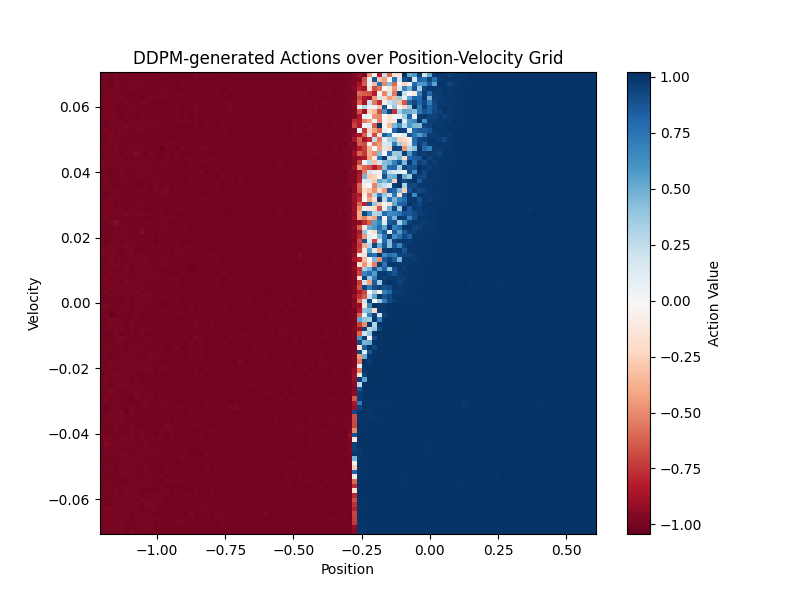

In [13]:
# 定义绘制DDPM生成的actions并使用pcolor映射的函数
def plot_ddpm_actions(policy_ddpm, env, grid_size=100):
    # 获取position和velocity的范围
    position_min, position_max = env.observation_space.low[0], env.observation_space.high[0]
    velocity_min, velocity_max = env.observation_space.low[1], env.observation_space.high[1]

    # 定义网格分辨率
    position_range = np.linspace(position_min, position_max, grid_size)
    velocity_range = np.linspace(velocity_min, velocity_max, grid_size)

    # 初始化action的存储矩阵
    actions = np.zeros((grid_size, grid_size))

    # 使用tqdm监控计算进度
    for i, position in enumerate(tqdm(position_range, desc="Processing positions")):
        for j, velocity in enumerate(velocity_range):
            # 将position和velocity组合成观察值
            observation = np.array([position, velocity])

            # 使用DDPM模型对每个网格点采样得到对应的action
            action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)

            # 确保 action 是标量，使用 .item() 提取值
            actions[i, j] = action[0].item()  # 将 action 存入网格

    # 绘制pcolor图
    plt.figure(figsize=(8, 6))
    plt.pcolor(position_range, velocity_range, actions, cmap='RdBu', shading='auto')
    plt.colorbar(label="Action Value")
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('DDPM-generated Actions over Position-Velocity Grid')
    plt.show()

# 主程序入口
if __name__ == '__main__':
    # 加载DDPM模型
    with open('./data/learned_policy_fixed_500.pkl', 'rb') as f:
        policy_ddpm = pkl.load(f)

    # 初始化MountainCarContinuous环境
    env = gym.make('MountainCarContinuous-v0', render_mode="human")

    # 调用函数绘制DDPM生成的 action 并使用 pcolor 映射
    plot_ddpm_actions(policy_ddpm, env)

    # 关闭环境
    env.close()

Processing positions: 100%|██████████| 100/100 [28:31<00:00, 17.11s/it]


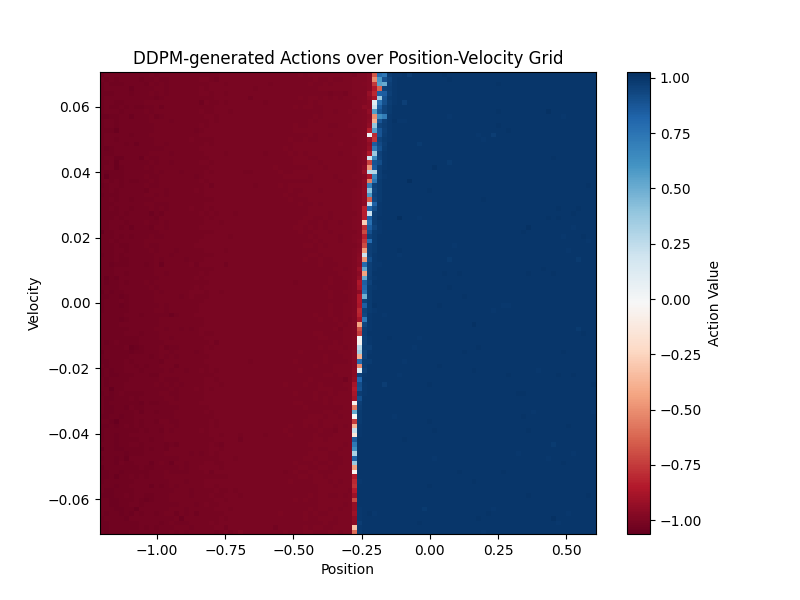

In [14]:
# 定义绘制DDPM生成的actions并使用pcolor映射的函数
def plot_ddpm_actions(policy_ddpm, env, grid_size=100):
    # 获取position和velocity的范围
    position_min, position_max = env.observation_space.low[0], env.observation_space.high[0]
    velocity_min, velocity_max = env.observation_space.low[1], env.observation_space.high[1]

    # 定义网格分辨率
    position_range = np.linspace(position_min, position_max, grid_size)
    velocity_range = np.linspace(velocity_min, velocity_max, grid_size)

    # 初始化action的存储矩阵
    actions = np.zeros((grid_size, grid_size))

    # 使用tqdm监控计算进度
    for i, position in enumerate(tqdm(position_range, desc="Processing positions")):
        for j, velocity in enumerate(velocity_range):
            # 将position和velocity组合成观察值
            observation = np.array([position, velocity])

            # 使用DDPM模型对每个网格点采样得到对应的action
            action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)

            # 确保 action 是标量，使用 .item() 提取值
            actions[i, j] = action[0].item()  # 将 action 存入网格

    # 绘制pcolor图
    plt.figure(figsize=(8, 6))
    plt.pcolor(position_range, velocity_range, actions, cmap='RdBu', shading='auto')
    plt.colorbar(label="Action Value")
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('DDPM-generated Actions over Position-Velocity Grid')
    plt.show()

# 主程序入口
if __name__ == '__main__':
    # 加载DDPM模型
    with open('./data/learned_policy_fixed_400.pkl', 'rb') as f:
        policy_ddpm = pkl.load(f)

    # 初始化MountainCarContinuous环境
    env = gym.make('MountainCarContinuous-v0', render_mode="human")

    # 调用函数绘制DDPM生成的 action 并使用 pcolor 映射
    plot_ddpm_actions(policy_ddpm, env)

    # 关闭环境
    env.close()

Calculating actions: 100%|██████████| 100/100 [27:51<00:00, 16.71s/it]


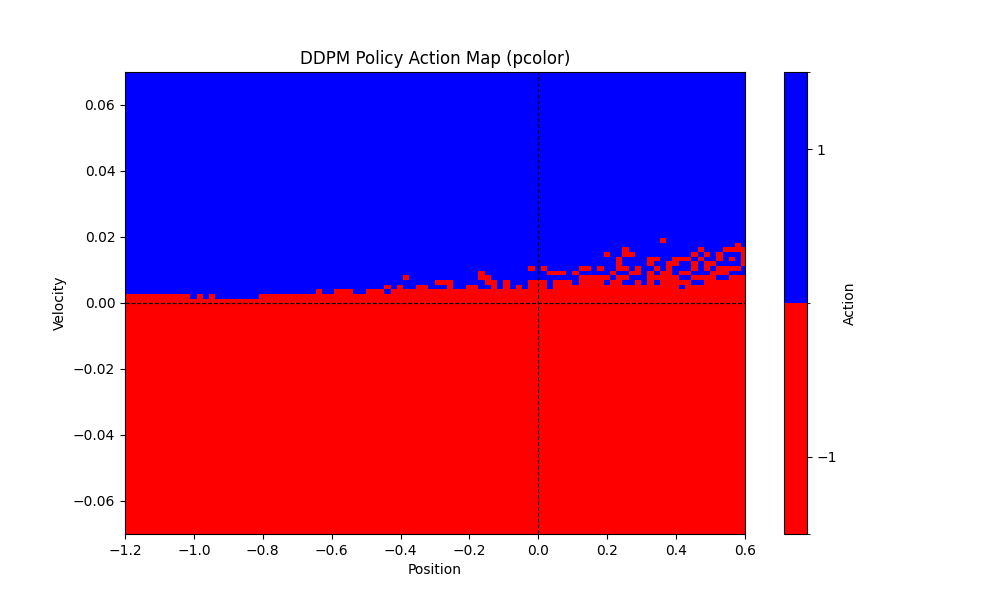

In [17]:
#get action from ddpm sampling
def get_ddpm_action(observation, policy_ddpm):
    # input tensor
    action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)
    return action[0].item()  # get scalar

# generate state grid
pos_range = np.linspace(-1.2, 0.6, 100)  # Position
vel_range = np.linspace(-0.07, 0.07, 100)  # Velocity

# create grid
X, Y = np.meshgrid(pos_range, vel_range)

# 初始化动作存储矩阵
actions = np.zeros(X.shape)

# 加载DDPM模型
with open('./data/learned_policy_fixed_500.pkl', 'rb') as f:
    policy_ddpm = pkl.load(f)

# calculate action from each grid
for i in tqdm(range(X.shape[0]), desc="Calculating actions"):
    for j in range(X.shape[1]):
        state = np.array([X[i, j], Y[i, j]])
        actions[i, j] = get_ddpm_action(state, policy_ddpm)

# 使用 pcolor 绘制动作
plt.figure(figsize=(10, 6))
cmap = mcolors.ListedColormap(['red', 'blue'])  # 自定义颜色映射
bounds = [-1.5, 0, 1.5]  # 动作的边界
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 绘制 pcolor 图
plt.pcolor(X, Y, actions, cmap=cmap, shading='auto', norm=norm)
plt.colorbar(ticks=[-1, 1], label='Action')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('DDPM Policy Action Map (pcolor)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # 添加水平线
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # 添加垂直线
plt.xlim(-1.2, 0.6)
plt.ylim(-0.07, 0.07)
plt.grid(False)  # 不显示网格
plt.show()

Calculating actions: 100%|██████████| 100/100 [32:01<00:00, 19.22s/it]


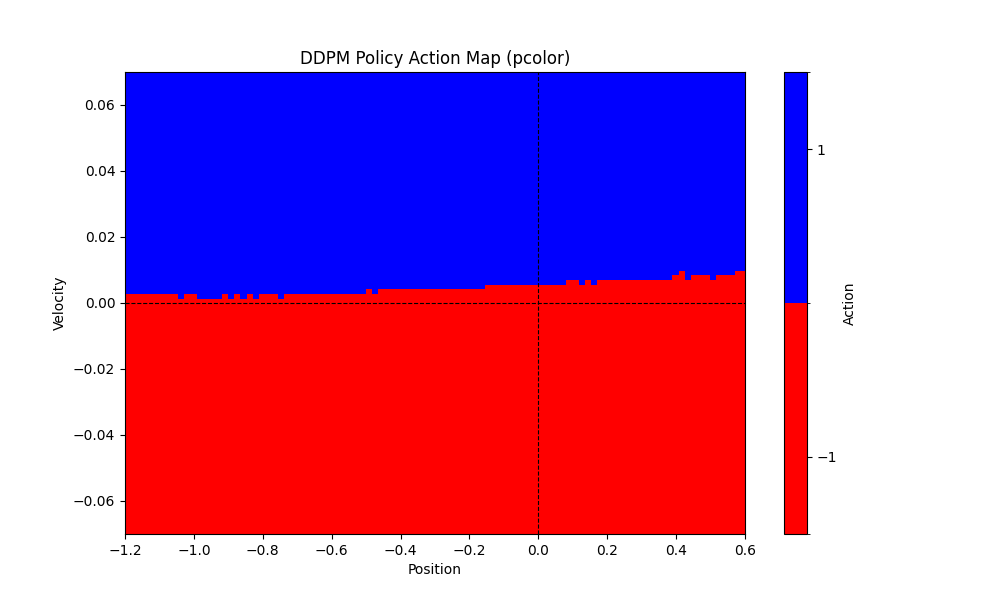

In [18]:
#get action from ddpm sampling
def get_ddpm_action(observation, policy_ddpm):
    # input tensor
    action = policy_ddpm.sampling(torch.tensor(observation).float(), n=1)
    return action[0].item()  # get scalar

# generate state grid
pos_range = np.linspace(-1.2, 0.6, 100)  # Position
vel_range = np.linspace(-0.07, 0.07, 100)  # Velocity

# create grid
X, Y = np.meshgrid(pos_range, vel_range)

# 初始化动作存储矩阵
actions = np.zeros(X.shape)

# 加载DDPM模型
with open('./data/learned_policy_fixed_400.pkl', 'rb') as f:
    policy_ddpm = pkl.load(f)

# calculate action from each grid
for i in tqdm(range(X.shape[0]), desc="Calculating actions"):
    for j in range(X.shape[1]):
        state = np.array([X[i, j], Y[i, j]])
        actions[i, j] = get_ddpm_action(state, policy_ddpm)

# 使用 pcolor 绘制动作
plt.figure(figsize=(10, 6))
cmap = mcolors.ListedColormap(['red', 'blue'])  # 自定义颜色映射
bounds = [-1.5, 0, 1.5]  # 动作的边界
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 绘制 pcolor 图
plt.pcolor(X, Y, actions, cmap=cmap, shading='auto', norm=norm)
plt.colorbar(ticks=[-1, 1], label='Action')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('DDPM Policy Action Map (pcolor)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # 添加水平线
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # 添加垂直线
plt.xlim(-1.2, 0.6)
plt.ylim(-0.07, 0.07)
plt.grid(False)  # 不显示网格
plt.show()